### Introduction

I am looking at NBA team data from 2001-02 through this past season (the cutoff is a bit arbitrary, it's related to the availability of some data on [Basketball Reference](https://www.basketball-reference.com)). I am using this data to predict the difference between the actual winning perecentage of teams and their expected winning percentage by [Pythagorean expectation](https://en.wikipedia.org/wiki/Pythagorean_expectation). My hunch is that performance in close games has some explanatory power for this dependent variable, but what exactly characterizes this type of performance -- is it defense, shooting, getting to the free throw line, simply having an extremely efficient superstar?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import statsmodels.formula.api as smf

import re

import bbref_scrape

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In particular, I wanted to scrape the [Four Factors](https://www.nbastuffer.com/analytics101/four-factors/), which some have found to correlate well with offensive/defensive success in basketball:
* **Effective Field Goal Pct.**: The percentage of shots made (adjusting for 3 point shots being worth more than 2 point shots
* **Offensive Rebounding Pct.**: The percentage of available offensive rebounds collected
* **Turnover Pct.**: The percentage of plays ending in a turnover
* **Free Throw Attempt Rate**: The free throw attempts per field goal attempts

Some of this data is included in the "Season Summary" pages from [Basketball Reference](https://www.basketball-reference.com). Here's an [example](https://www.basketball-reference.com/leagues/NBA_2018.html) -- there are lots of tables in here summarizing a wide array of stats for each team over the course of a single season.

Below I scrape everything from the 2001-02 through 2017-18 seasons and then do some cleanup of the eventual dataframe. Also calculate the win percentage, Pythag win percentage, and the difference between them:

In [2]:
# scrape from team pages the "Miscellaneous Stats" table
years = np.arange(2002, 2019)
#summ_tbl_strings = ['team-stats-base', 'opponent-stats-base', 'misc_stats', 'team_shooting', 'opponent_shooting']
summ_tbl_strings = ['misc_stats']

df = pd.DataFrame()

for yr in years:
    df2 = pd.DataFrame()
    for string in summ_tbl_strings:
        tmp = bbref_scrape.tbl_scrape_from_bbref_seasonsumm(string, yr)
        df2 = pd.concat([df2, tmp], axis=1)
    df = pd.concat([df, df2])

The data, even the numeric data, are read in as strings, so below I first convert everything as such. Then, I compute the actual winning percentage and the Pythag winning percentage (`PW` and `PL` are the Pythag wins and losses that are included in the scraped table). 

I then compute `diffWP` as the difference between actual and expected (Pythag) winning percentage. If this difference is positive (negative), a team can be said to have overperformed (underperformed).

In [3]:
# convert numerics (which are strings) to numerics
# then calculate WP as Win% (WP)
# then calculate expected Win% (xWP) (i.e., Pythag Win%)
# then the difference and drop teams with fewer than 30 wins (teams that were tanking may not be relevant)
df = df.apply(pd.to_numeric, errors='ignore')
df['WP'] = df['W']/(df['W'] + df['L'])
df['xWP'] = df['PW']/(df['PW'] + df['PL'])
df['diffWP'] = df['WP'] - df['xWP']

In [4]:
df.shape

(507, 28)

Each year a lot of teams are more or less intentionally losing (tanking) which may have some impact on the results. Let's remove those teams from the dataset for now and examine correlations between the features and the response `diffWP`.

For the time being, let's denote teams that win fewer than 30 games in a season as teams that are tanking. Since the 2011-12 season is included in this data and was a strike-shortened season with fewer games than a standard season, I'm using the equivalent of the (actual) winning percentage for a 30 win season below. 

In [5]:
dfnotank = df[df['WP'] >= 0.366]

Let's drop some columns corresponding to potential features used to compute `diffWP` such as `W`, `L`, `PW`, `PL`, `WP` and `xWP`, and take a look at the distribution of `diffWP` and the correlations between the response `diffWP` and remaining features.

In [6]:
dfnotank.drop(['WP', 'xWP', 'W', 'L', 'PW', 'PL', 'Arena', 'Attend.', 'Attend./G', 'SRS', 'MOV', 'ORtg', 'DRtg'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
dfnotank.shape

(391, 15)

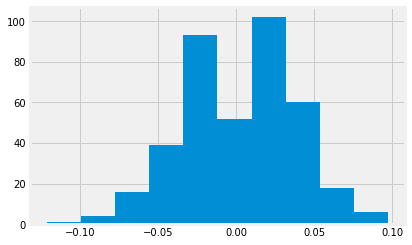

In [8]:
dfnotank['diffWP'].hist()

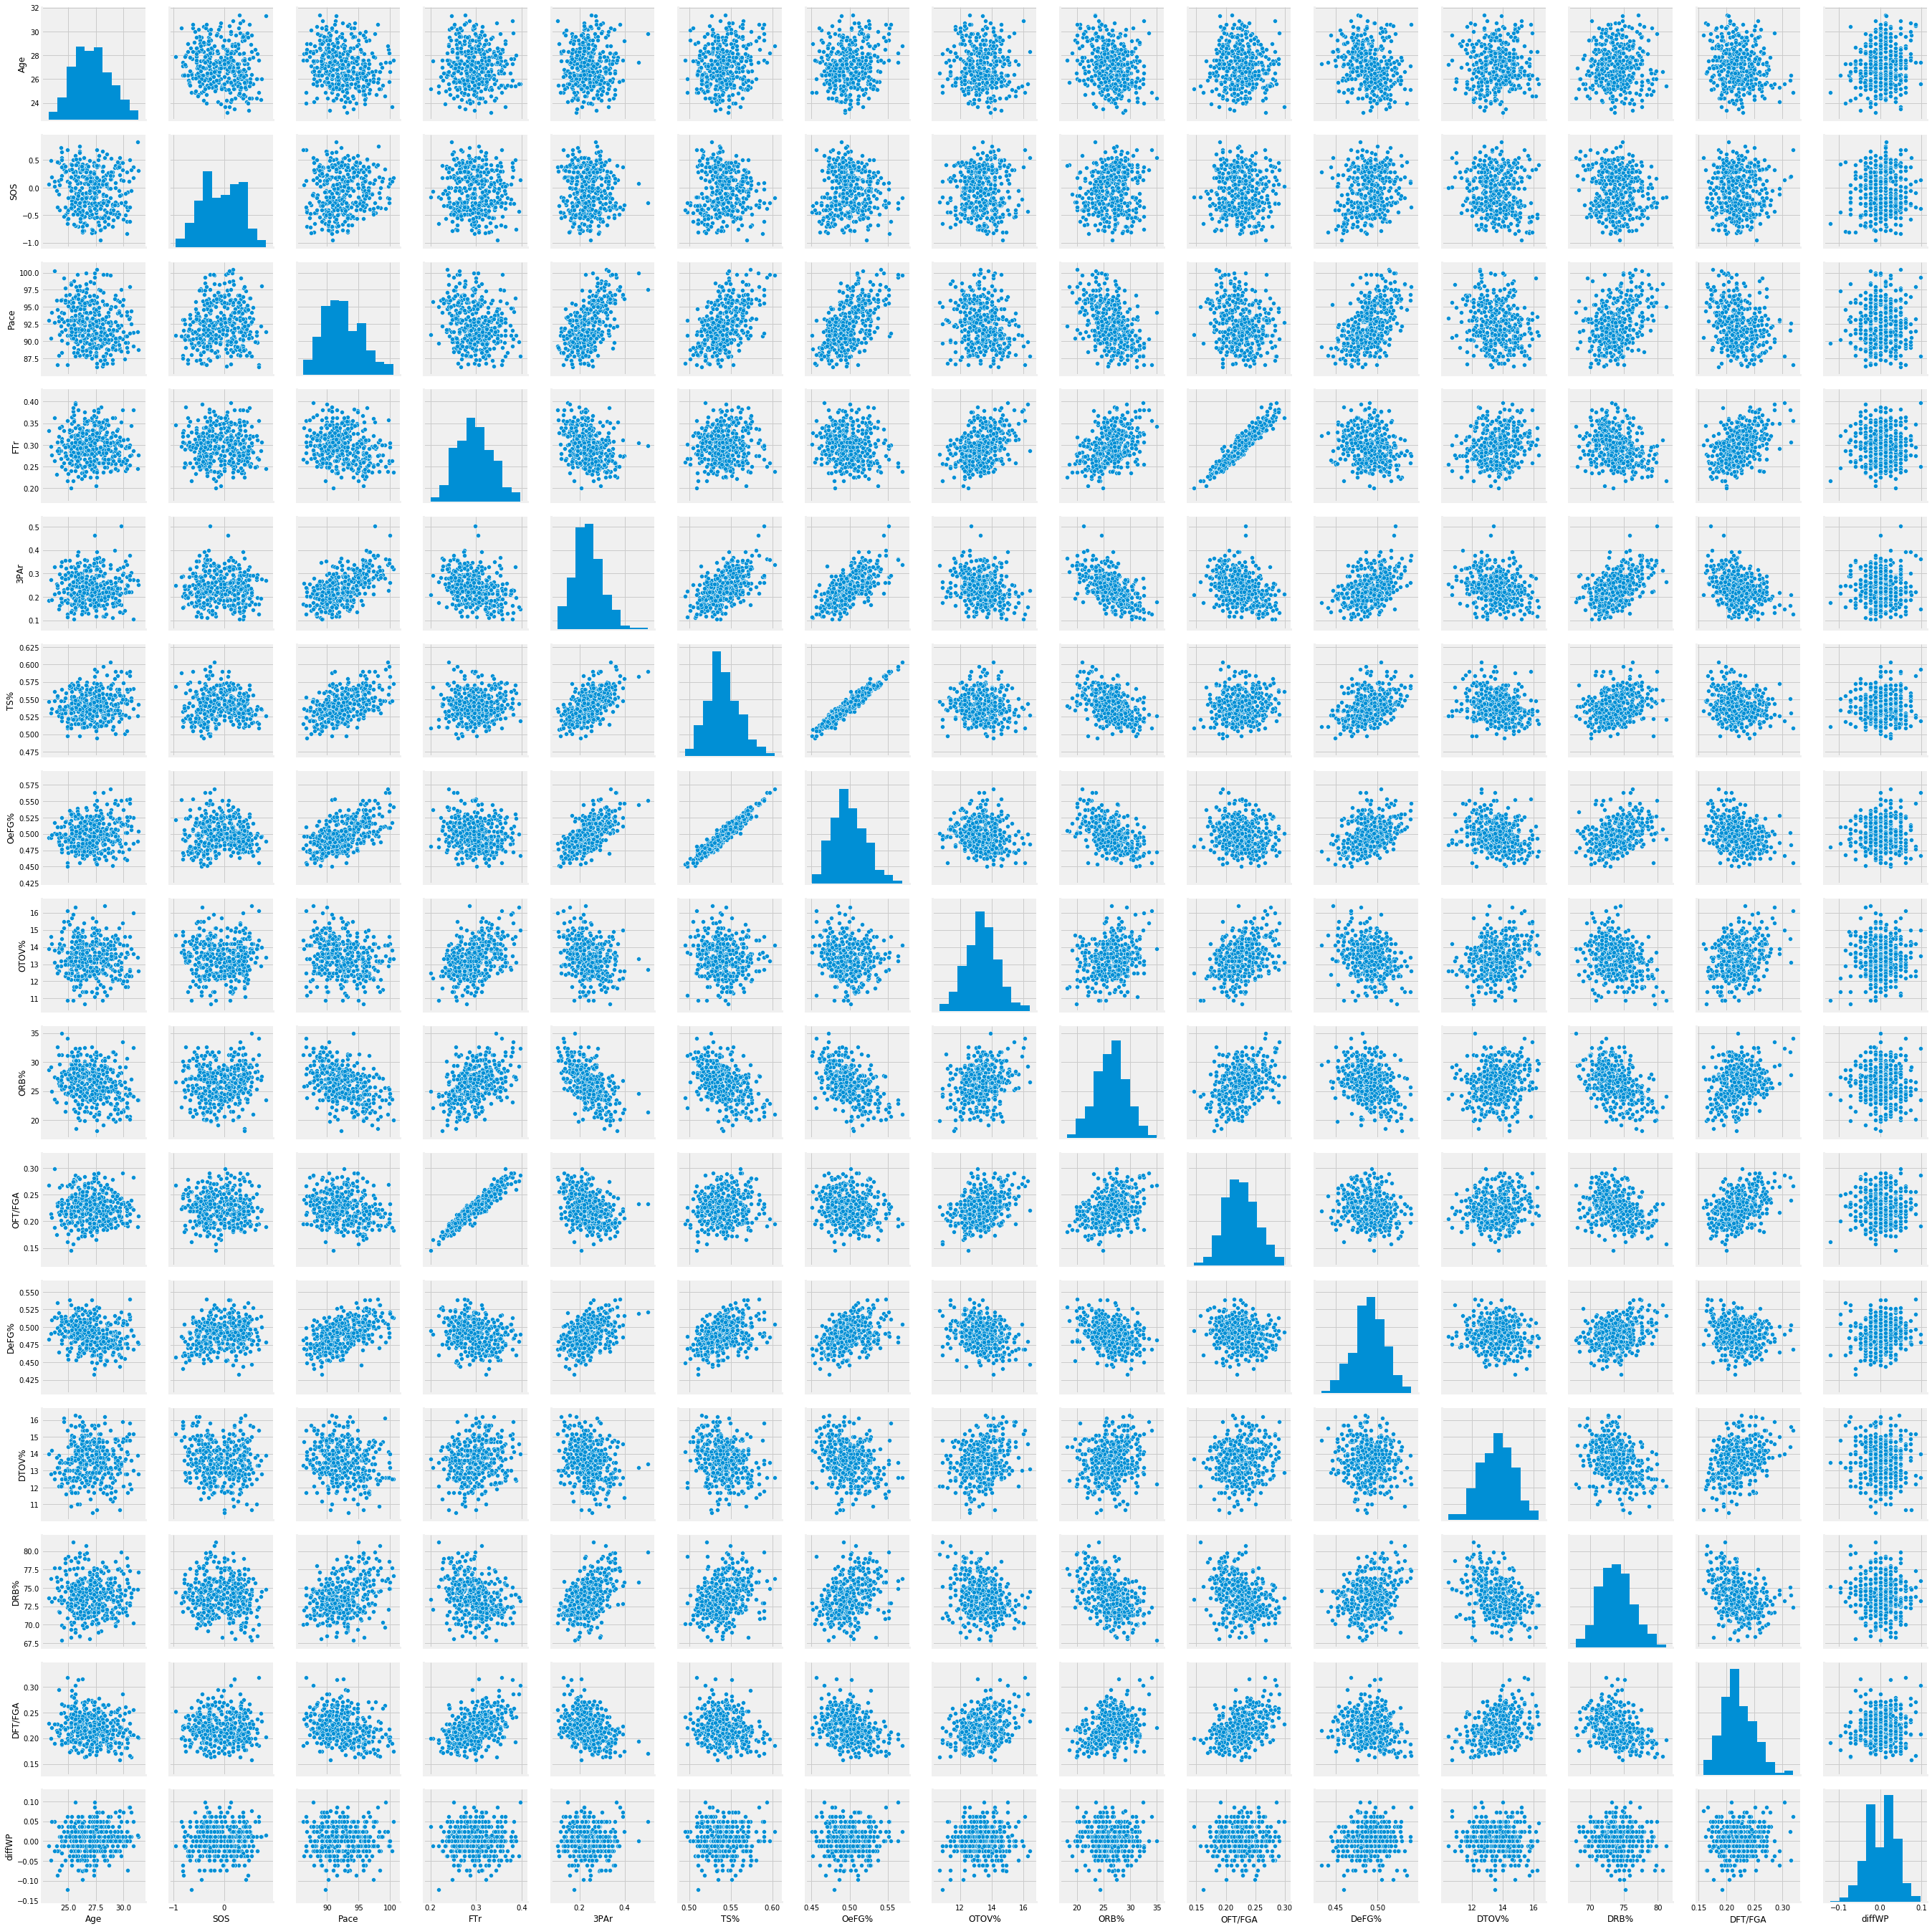

In [9]:
sns.pairplot(dfnotank)

There are few strong correlations (for a linear relationship) between `diffWP` and some of the potential features. There appears to be a fair amount of collinearity between features. This is to be expected, considering (for example) that all of the "four factors" are supposed to be highly correlated with Offensive Rating `ORtg` and Defensive Rating `DRtg`.

Let us run an initial model now even considering the above.

In [10]:
# add an intercept column
dfnotank['Ones'] = np.ones(len(dfnotank))

# add year column to facilitate test-train split
dfnotank['Year'] = [int(re.search('\d+$', teamyr).group(0)) for teamyr in dfnotank.index]

# split into train, test, holdout by years
dftrainbase = dfnotank[dfnotank['Year'] <= 2017]
dftrain = dfnotank[dfnotank['Year'] <= 2012]
dftest = dfnotank[(dfnotank['Year'] > 2012) & (dfnotank['Year'] <= 2017)]
dfholdout = dfnotank[dfnotank['Year'] > 2017]

# training set (baseline)
Ytrainbase = dftrainbase['diffWP']
Xtrainbase = dftrainbase.drop(['diffWP', 'Year'], axis=1)

# training set
Ytrain = dftrain['diffWP']
Xtrain = dftrain.drop(['diffWP', 'Year'], axis = 1)

# test set
Ytest = dftest['diffWP']
Xtest = dftest.drop(['diffWP','Year'], axis = 1)

# holdout set
Yholdout = dfholdout['diffWP']
Xholdout = dfholdout.drop(['diffWP','Year'], axis = 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
lml = sm.OLS(Ytrainbase,Xtrainbase)

In [12]:
fit = lml.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 diffWP   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.100
Date:                Mon, 17 Sep 2018   Prob (F-statistic):           0.000142
Time:                        15:49:12   Log-Likelihood:                 736.32
No. Observations:                 370   AIC:                            -1443.
Df Residuals:                     355   BIC:                            -1384.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0050      0.001      3.994      0.000       0.003       0.008
SOS            0.0008      0.005      0.161      0.872      -0.009       0.011
Pace           0.0001      0.001      0.143      0.887      -0.001       0.002
FTr            1.2804      0.786      1.628      0.104      -0.266       2.827
3PAr          -0.0545      0.047     -1.172      0.242      -0.146       0.037
TS%            5.7159      3.659      1.562      0.119      -1.480      12.912
OeFG%         -5.1848      3.241     -1.600      0.111     -11.559       1.189
OTOV%          0.0043      0.002      2.072      0.039       0.000       0.008
ORB%          -0.0005      0.001     -0.542      0.588      -0.002       0.001
OFT/FGA       -2.7120      1.632     -1.662      0.097      -5.921       0.497
DeFG%          0.5110      0.124      4.106      0.000       0.266       0.756
DTOV%         -0.0064      0.002     -3.300      0.001      -0.010      -0.003
DRB%          -0.0018      0.001     -1.873      0.062      -0.004    8.91e-05
DFT/FGA        0.1138      0.079      1.446      0.149      -0.041       0.269
Ones          -0.5080      0.272     -1.870      0.062      -1.042       0.026
==============================================================================
Omnibus:                        0.051   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.975   Jarque-Bera (JB):                0.122
Skew:                          -0.022   Prob(JB):                        0.941
Kurtosis:                       2.922   Cond. No.                     3.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This mostly doesn't appear that promising -- $R^2$ is quite low even though other indicators (e.g., F-test) suggest significance of the overall model and the only features that appear promising are average age of team `Age`, true shooting percentage `TS%` and offensive and defensive rating `ORtg` and `DRtg`.

Let's compute and examine residuals to see if the data at least meet the assumptions of linear regression.

(array([ 5., 12., 41., 60., 91., 75., 48., 31.,  6.,  1.]),
 array([-0.09423469, -0.07446795, -0.05470122, -0.03493448, -0.01516774,
         0.00459899,  0.02436573,  0.04413247,  0.0638992 ,  0.08366594,
         0.10343268]),
 <a list of 10 Patch objects>)

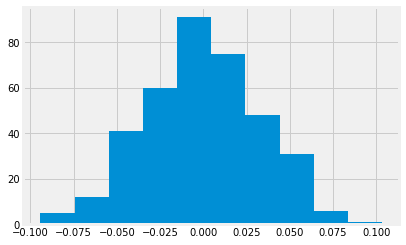

In [13]:
# histogram of residuals
Ytrainbase_pred = fit.predict(Xtrainbase)
res = Ytrainbase - Ytrainbase_pred
plt.hist(res)

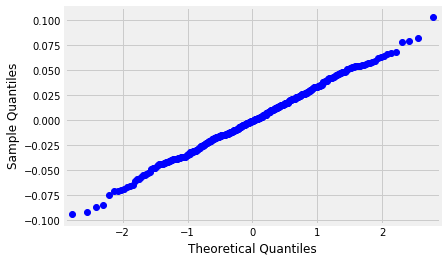

In [15]:
# Q-Q plot of residuals
sm.qqplot(res)
plt.show()

The above Q-Q plot and histogram don't appear to indicate that any violation of the assumption that the residuals are normall distributed. Let's look at a scatter of the residuals to see about homoscedasticity and no autocorrelation.

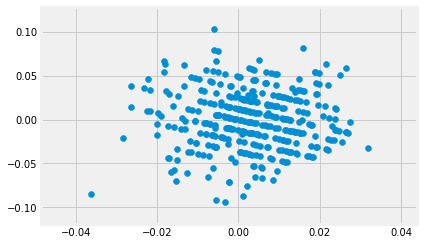

In [16]:
# residuals vs. fit
plt.scatter(Ytrainbase_pred, res)
plt.show()

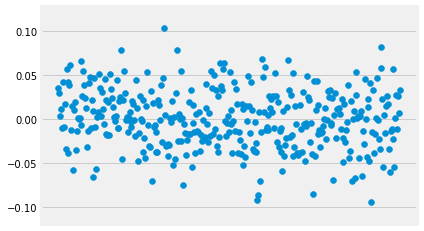

In [17]:
# residuals vs. observation
plt.scatter(Xtrainbase.index, res)
plt.xticks([])
plt.show()

OK, the above looks quite satisfactory to me in meeting linear regression assumptions. Let's now take a look at performance on the test set.

In [18]:
Yholdout_pred = fit.predict(Xholdout)
SE = (Yholdout - Yholdout_pred) ** 2
ST = (Yholdout - Yholdout.mean()) ** 2
Rsq_holdout = 1 - (sum(SE)/sum(ST))
Rsq_holdout

0.13289997512863394

OK, we can probably conclude now that the model is underfit or just does not include the adequate set of features. But let's perform some regularization and feature selection anyhow. Start with "Select K Best".

In [19]:
from sklearn import preprocessing, linear_model, pipeline, model_selection, feature_selection, metrics

In [20]:
dfnotank.columns.values

array(['Age', 'SOS', 'Pace', 'FTr', '3PAr', 'TS%', 'OeFG%', 'OTOV%',
       'ORB%', 'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'diffWP',
       'Ones', 'Year'], dtype=object)

In [21]:
select_pipe = pipeline.Pipeline(
    [("std", preprocessing.StandardScaler()),
    ("select",
      feature_selection.SelectKBest(
          score_func=feature_selection.f_regression, k=3)),
     ("ols", linear_model.LinearRegression())])
select_pipe.get_params()

{'memory': None,
 'ols': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'ols__copy_X': True,
 'ols__fit_intercept': True,
 'ols__n_jobs': 1,
 'ols__normalize': False,
 'select': SelectKBest(k=3, score_func=<function f_regression at 0x1c21fce6a8>),
 'select__k': 3,
 'select__score_func': <function sklearn.feature_selection.univariate_selection.f_regression>,
 'std': StandardScaler(copy=True, with_mean=True, with_std=True),
 'std__copy': True,
 'std__with_mean': True,
 'std__with_std': True,
 'steps': [('std', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('select',
   SelectKBest(k=3, score_func=<function f_regression at 0x1c21fce6a8>)),
  ('ols',
   LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]}

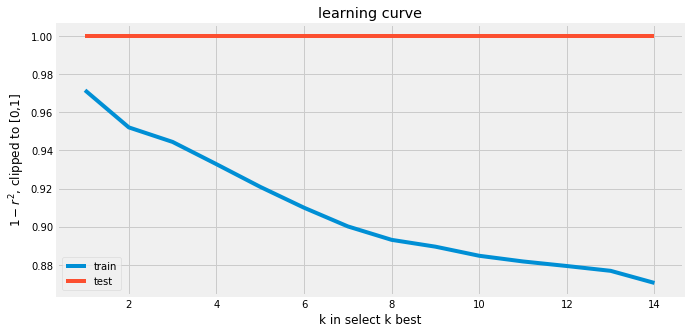

In [39]:
plt.figure(figsize=(10,5))
train_scores = []
test_scores = []
num_fs = range(1, len(Xtrain.columns), 1)
for i, num_f in enumerate(num_fs):
    select_pipe.set_params(select__k=num_f)
    train_splits = []
    test_splits = []
    for yr in range(2012, 2017):
        dftrain = dfnotank[dfnotank['Year'] <= yr]
        dftest = dfnotank[(dfnotank['Year'] > yr) & (dfnotank['Year'] <= 2017)]
        
        Y = dftrain['diffWP']
        X = dftrain.drop(['diffWP', 'Year'], axis = 1)
        Ytest = dftest['diffWP']
        Xtest = dftest.drop(['diffWP', 'Year'], axis = 1)
        
        fit = select_pipe.fit(X.drop('Ones', axis=1), Y)
        train_splits.append(fit.score(X.drop('Ones', axis=1), Y))
        test_splits.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))
        
    train_scores.append(np.mean(train_splits))
    test_scores.append(np.mean(test_splits))

plt.plot(num_fs, 1 - np.array(train_scores), label="train")
plt.plot(num_fs, 1 - np.maximum(test_scores, 0), label="test")
plt.xlabel("k in select k best")
plt.ylabel("$1-r^2$, clipped to [0,1]")
plt.title("learning curve")
plt.legend()

In [23]:
select_pipe.set_params(select__k=4)
fit = select_pipe.fit(Xtrainbase.drop('Ones', axis=1),Ytrainbase)
features = select_pipe.named_steps['select']
features.get_support()

array([ True,  True, False, False, False, False, False, False, False,
       False,  True, False,  True, False])

In [40]:
best_i = np.argmax(test_scores)

In [41]:
np.mean(test_scores[best_i])

-0.02764439917818784

In [42]:
np.mean(train_scores[best_i])

0.12943961051883238

In [24]:
Xtrain.drop('Ones', axis=1).columns[features.get_support()]

Index(['Age', 'SOS', 'DeFG%', 'DRB%'], dtype='object')

In [25]:
fit.score(Xtrainbase.drop('Ones', axis=1), Ytrainbase)

0.05957061080117443

In [26]:
fit.score(Xholdout.drop('Ones', axis=1), Yholdout)

0.11210608934765898

This doesn't appear to help things? Let's try ridge.

In [27]:
ridge_pipe = pipeline.Pipeline([ 
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("ridge", linear_model.Ridge())
    ])

In [28]:
# alphas look best when logspaced
alphas = np.logspace(5, .5, num=50)
coefs = []
train_scores = []
test_scores = []
preds = []
fits = []

# loop through each of the 50 alphas
for i, alpha in enumerate(alphas):
    # set the alpha for our pipeline
    ridge_pipe.set_params(ridge__alpha=alpha)
    
    train_splits = []
    test_splits = []
    
    for yr in range(2012, 2017):
        dftrain = dfnotank[dfnotank['Year'] <= yr]
        dftest = dfnotank[(dfnotank['Year'] > yr) & (dfnotank['Year'] <= 2017)]
        
        Y = dftrain['diffWP']
        X = dftrain.drop(['diffWP', 'Year'], axis = 1)
        Ytest = dftest['diffWP']
        Xtest = dftest.drop(['diffWP', 'Year'], axis = 1)
        
        fit = ridge_pipe.fit(X.drop('Ones', axis=1), Y)
        train_splits.append(fit.score(X.drop('Ones', axis=1), Y))
        test_splits.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))
        
    train_scores.append(np.mean(train_splits))
    test_scores.append(np.mean(test_splits))
    
    fit_train = ridge_pipe.fit(Xtrainbase.drop('Ones', axis=1), Ytrainbase)
    fits.append(fit_train)
    preds.append(fit_train.predict(Xtrain.drop('Ones', axis=1)))
    coefs.append(ridge_pipe.named_steps["ridge"].coef_)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


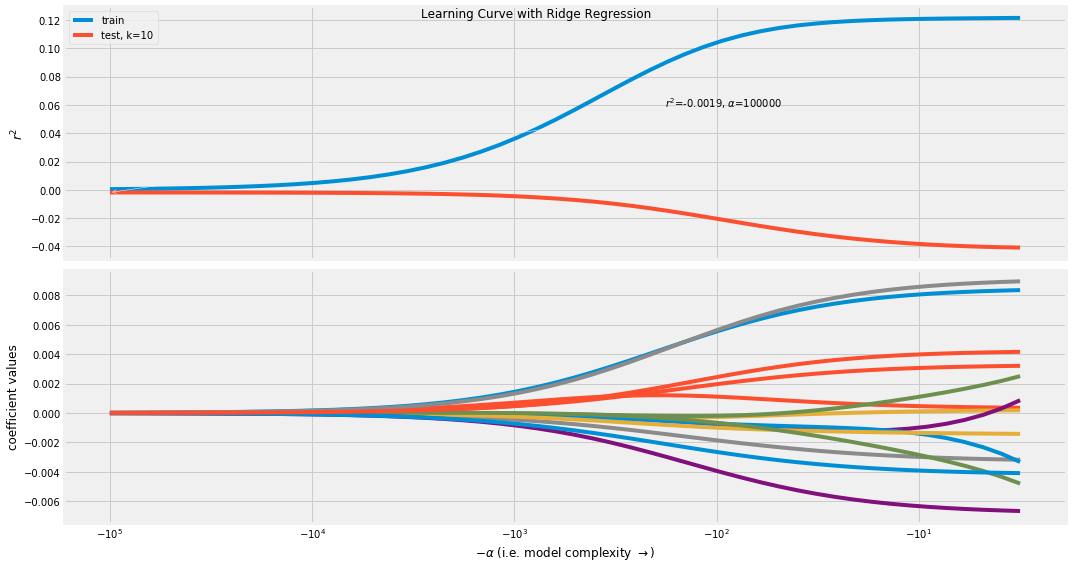

In [30]:
# set up the figure. I'll do the learning curve above and coefficient path below
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
# list of arrays -> single array
coef_arr = np.squeeze(coefs, axis=1)
# grab the first axis
ax0 = axes.flat[0]
# plot train and test curves
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
# find the index of the best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

# grab the second axis
ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Ridge Regression")
plt.xscale("symlog")

In [31]:
best_fit = fits[best_i]
best_fit.score(Xtrainbase.drop('Ones', axis=1), Ytrainbase)

0.10282490464227856

In [32]:
best_fit.score(Xholdout.drop('Ones', axis=1), Yholdout)

0.11559165169973373

In [33]:
np.mean(test_scores[best_i])

-0.0018559569859773362

In [34]:
np.mean(train_scores[best_i])

0.0004971759620750138

In [35]:
sorted(list(zip(Xtrainbase.columns, coefs[best_i])), key=lambda t: abs(t[1]), reverse=True)

[('Age', 1.773981934254941e-05),
 ('DeFG%', 1.5566545317645186e-05),
 ('SOS', 1.0777812808456981e-05),
 ('DRB%', -9.571515412554164e-06),
 ('DTOV%', -9.438307991444628e-06),
 ('DFT/FGA', 5.9142750146067005e-06),
 ('3PAr', -5.784032430499829e-06),
 ('OTOV%', 5.5963987035439285e-06),
 ('Pace', -2.713173040769519e-06),
 ('ORB%', -2.457546134707124e-06),
 ('OeFG%', -1.3301462925115911e-06),
 ('OFT/FGA', 9.888136089911742e-07),
 ('TS%', -4.642023134180215e-07),
 ('FTr', 3.2504429089864404e-07)]

This particular data doesn't seem promising -- in training $R^2$ appears to be poor and in test, things get even worse. Any issues with collinearity don't appear to be resolved as well, as the largest coefficient values are not entirely independent. `MOV`, team margin of victory correlates with `SRS` (Basketball-Reference's  custom statistic for team strength accounting for schedule and margin of victory) and `DRtg` (a measure of points allowed by a team per 100 possessions).

I am going to move on and look at data from NBA.com for clutch performance.

In [36]:
import pickle

In [37]:
with open('bbref_team_all_02_18.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

In [38]:
with open('bbref_team_notank_02_18.pkl', 'wb') as picklefile2:
    pickle.dump(dfnotank, picklefile2)